Load data into dataset using pandas

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib  # to save models

# Load data
df = pd.read_excel("../data/FAOSTAT_data.xlsx")
df.head()


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371,"Almonds, in shell",2019,2019,ha,29203.0,A,Official figure,NaN
1,QCL,Crops and livestock products,4,Afghanistan,5412,Yield,1371,"Almonds, in shell",2019,2019,kg/ha,1308.3,A,Official figure,NaN
2,QCL,Crops and livestock products,4,Afghanistan,5510,Production,1371,"Almonds, in shell",2019,2019,t,38205.0,A,Official figure,NaN
3,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371,"Almonds, in shell",2020,2020,ha,22134.0,A,Official figure,NaN
4,QCL,Crops and livestock products,4,Afghanistan,5412,Yield,1371,"Almonds, in shell",2020,2020,kg/ha,1775.9,A,Official figure,NaN


Transform the data:

In [6]:
# Pivoting the data to wide format
df_wide = df.pivot_table(
    index=['Area', 'Item', 'Year'],
    columns='Element',
    values='Value'
).reset_index()

# Rename columns for easier use
df_wide.rename(columns={
    'Area harvested': 'Area_Harvested',
    'Yield': 'Yield_kg_per_ha',
    'Production': 'Production_tons'
}, inplace=True)

df_wide.head()



Element,Area,Item,Year,Area_Harvested,Laying,Milk Animals,Producing Animals/Slaughtered,Production_tons,Stocks,Yield_kg_per_ha,Yield/Carcass Weight
0,Afghanistan,"Almonds, in shell",2019,29203.0,NaN,NaN,NaN,38205.0,NaN,1308.3,NaN
1,Afghanistan,"Almonds, in shell",2020,22134.0,NaN,NaN,NaN,39307.0,NaN,1775.9,NaN
2,Afghanistan,"Almonds, in shell",2021,36862.0,NaN,NaN,NaN,64256.0,NaN,1743.2,NaN
3,Afghanistan,"Almonds, in shell",2022,36462.0,NaN,NaN,NaN,63515.0,NaN,1742.0,NaN
4,Afghanistan,"Almonds, in shell",2023,37000.0,NaN,NaN,NaN,67000.0,NaN,1810.8,NaN


Since Project goal is Predict Crop Production , we can filter the data to include only crops

In [7]:
# Filter only crop records (i.e., where 'Area_Harvested' is not null)
df_crops = df_wide[df_wide['Area_Harvested'].notna()]

# Optional: drop irrelevant livestock columns to clean up
df_crops = df_crops[['Area', 'Item', 'Year', 'Area_Harvested', 'Yield_kg_per_ha', 'Production_tons']]


In [4]:
df_crops.head()

Element,Area,Item,Year,Area_Harvested,Yield_kg_per_ha,Production_tons
0,Afghanistan,"Almonds, in shell",2019,29203.0,1308.3,38205.0
1,Afghanistan,"Almonds, in shell",2020,22134.0,1775.9,39307.0
2,Afghanistan,"Almonds, in shell",2021,36862.0,1743.2,64256.0
3,Afghanistan,"Almonds, in shell",2022,36462.0,1742.0,63515.0
4,Afghanistan,"Almonds, in shell",2023,37000.0,1810.8,67000.0


Check for nulls:

In [8]:
print(df_crops.isnull().sum())

Element
Area                  0
Item                  0
Year                  0
Area_Harvested        0
Yield_kg_per_ha    2920
Production_tons     182
dtype: int64


Drop rows with missing values for 'Area_Harvested', 'Yield_kg_per_ha', 'Production_tons'

In [9]:
df_crops_clean = df_crops.dropna(subset=['Area_Harvested', 'Yield_kg_per_ha', 'Production_tons'])


In [10]:
df_crops_clean.head()

Element,Area,Item,Year,Area_Harvested,Yield_kg_per_ha,Production_tons
0,Afghanistan,"Almonds, in shell",2019,29203.0,1308.3,38205.0
1,Afghanistan,"Almonds, in shell",2020,22134.0,1775.9,39307.0
2,Afghanistan,"Almonds, in shell",2021,36862.0,1743.2,64256.0
3,Afghanistan,"Almonds, in shell",2022,36462.0,1742.0,63515.0
4,Afghanistan,"Almonds, in shell",2023,37000.0,1810.8,67000.0


Show count of nulls in each column:

In [11]:
print(df_crops_clean.isnull().sum())


Element
Area               0
Item               0
Year               0
Area_Harvested     0
Yield_kg_per_ha    0
Production_tons    0
dtype: int64


Find unique values of the columns:

In [12]:
print("Area Unique values:" ,df_crops_clean['Area'].nunique())
print("Item Unique values:" ,df_crops_clean['Item'].nunique())
print("Year Unique values:" ,df_crops_clean['Year'].nunique())


Area Unique values: 200
Item Unique values: 157
Year Unique values: 5


So there are 200 countries with 157 different crops grown and data for 5 years.

One-hot encode categorical columns:

In [13]:

df_encoded = pd.get_dummies(df_crops_clean, columns=['Area', 'Item'], drop_first=True)

Define features and Target:

In [14]:
X = df_encoded.drop(columns=['Production_tons'])  # Features
y = df_encoded['Production_tons']                 # Target


In [15]:
X.head()

,Year,Area_Harvested,Yield_kg_per_ha,Area_Albania,Area_Algeria,Area_Angola,Area_Antigua and Barbuda,Area_Argentina,Area_Armenia,Area_Australia,...,"Item_True hemp, raw or retted",Item_Tung nuts,Item_Unmanufactured tobacco,"Item_Vanilla, raw",Item_Vetches,"Item_Walnuts, in shell",Item_Watermelons,Item_Wheat,Item_Yams,Item_Yautia
0,2019,29203.0,1308.3,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2020,22134.0,1775.9,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2021,36862.0,1743.2,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2022,36462.0,1742.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2023,37000.0,1810.8,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Split data for Training and Testing :

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Linear Regression Model:

In [17]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Random Forest Regressor Model:

In [18]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Gradient Boosting Regressor:

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
gb_model.fit(X_train, y_train)


,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


KNN:

In [20]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)




,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [22]:
def evaluate_model(y_true, y_pred):
    # Convert to numpy arrays (if not already)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Filter out zero values in y_true to avoid division by zero in MAPE
    non_zero_mask = y_true != 0
    y_true_non_zero = y_true[non_zero_mask]
    y_pred_non_zero = y_pred[non_zero_mask]
    
    # Metrics
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100

    return r2, mse, mae, mape


In [23]:
# Predict using models
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)

# Evaluate each model
metrics_lr = evaluate_model(y_test, y_pred_lr)
metrics_rf = evaluate_model(y_test, y_pred_rf)
metrics_gb = evaluate_model(y_test, y_pred_gb)
metrics_knn = evaluate_model(y_test, y_pred_knn)

# Create results DataFrame
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'KNN'],
    'R2 Score': [metrics_lr[0], metrics_rf[0], metrics_gb[0], metrics_knn[0]],
    'MSE': [metrics_lr[1], metrics_rf[1], metrics_gb[1], metrics_knn[1]],
    'MAE': [metrics_lr[2], metrics_rf[2], metrics_gb[2], metrics_knn[2]],
    'MAPE (%)': [metrics_lr[3], metrics_rf[3], metrics_gb[3], metrics_knn[3]],
})

# Format numeric columns for nice display (rounded & no scientific notation)
for col in ['R2 Score', 'MSE', 'MAE', 'MAPE (%)']:
    if col == 'R2 Score':
        # Round to 4 decimals for R2 score
        results[col] = results[col].apply(lambda x: f"{x:.4f}")
    else:
        # Format others with comma separator, 2 decimals, no scientific notation
        results[col] = results[col].apply(lambda x: f"{x:,.2f}")

# Print the nicely formatted results table
print(results.to_string(index=False))


            Model R2 Score                   MSE          MAE     MAPE (%)
Linear Regression   0.4312 76,606,799,285,629.22 1,705,692.18 2,419,985.43
    Random Forest   0.9982    236,073,422,072.58    38,006.79         1.79
Gradient Boosting   0.9916  1,125,199,563,509.47   245,179.35   126,629.62
              KNN   0.7917 28,055,952,527,799.39   374,668.86       132.60


In [25]:

import matplotlib.pyplot as plt
import seaborn as sns

# Convert numeric columns back to float for plotting
results_plot = results.copy()
for col in ['R2 Score', 'MSE', 'MAE', 'MAPE (%)']:
    results_plot[col] = results_plot[col].str.replace(',', '').astype(float)



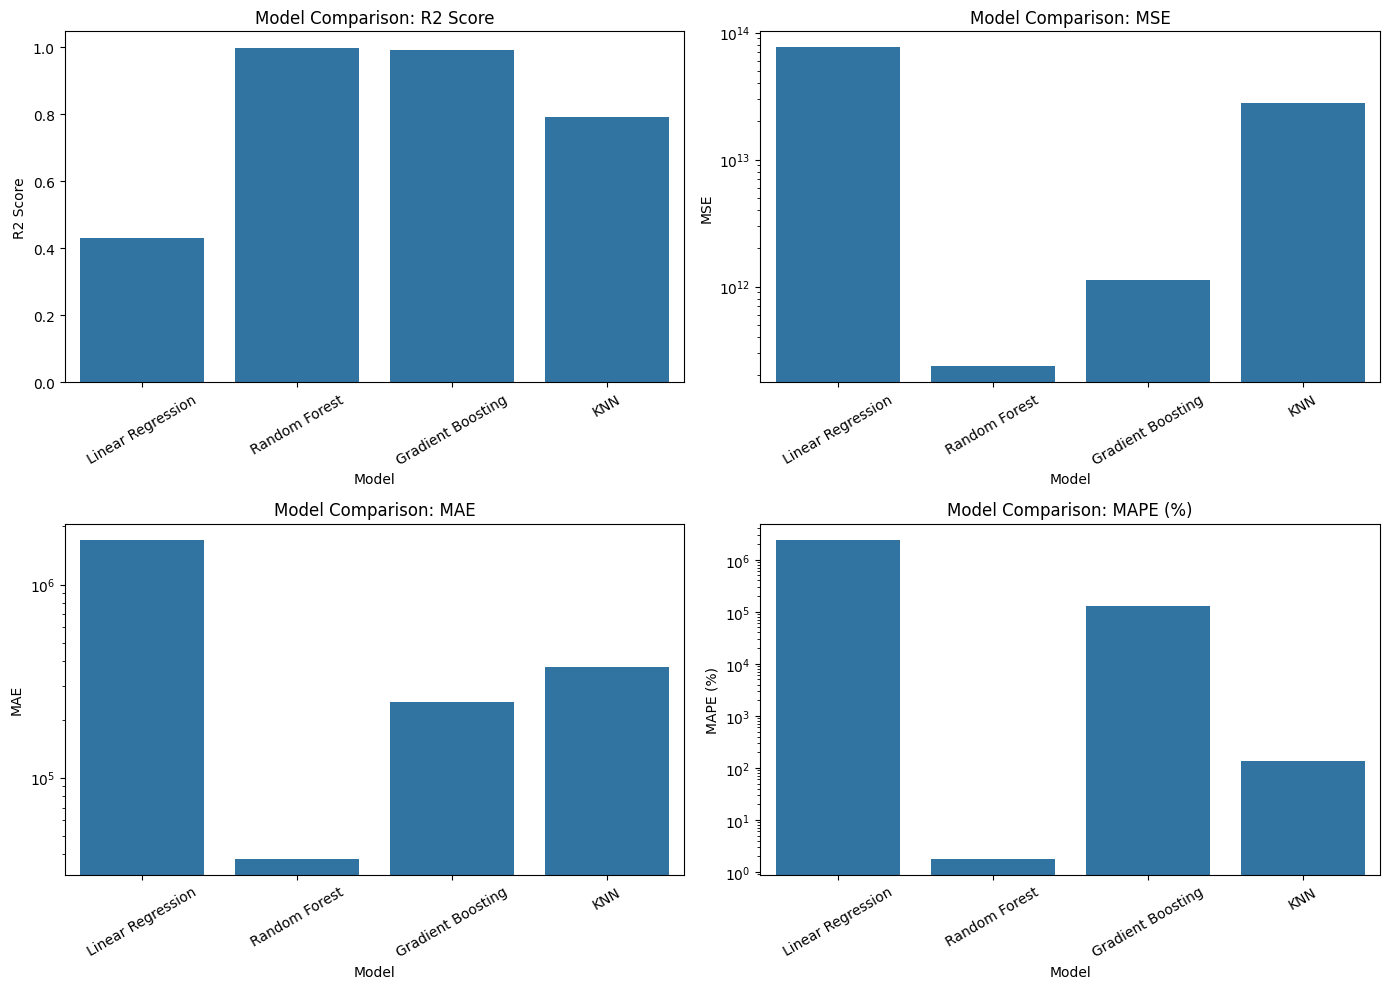

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['R2 Score', 'MSE', 'MAE', 'MAPE (%)']

for ax, metric in zip(axs.flatten(), metrics):
    sns.barplot(data=results_plot, x='Model', y=metric, ax=ax)
    ax.set_title(f'Model Comparison: {metric}')
    ax.tick_params(axis='x', rotation=30)  # Rotate x-axis labels properly
    if metric in ['MSE', 'MAE', 'MAPE (%)']:
        ax.set_yscale('log')  # log scale for large values

plt.tight_layout()
plt.show()


Random Forest looks like the clear winner here:

It has the highest R² (~0.9982), meaning it explains almost all the variance.

It has the lowest MSE and MAE — much better than Linear Regression and Gradient Boosting.

Its MAPE is very low (~1.79%), showing good prediction accuracy relative to actual values.

So Random Forest is a solid choice for crop production prediction model

Saving the Random Forest Model

In [27]:
import joblib

# Assuming your trained random forest model variable is rf_model
joblib.dump(rf_model, 'rf_model_crop_production.pkl')


['rf_model_crop_production.pkl']

 Save Data to MySQL Workbench (MySQL Database)

In [28]:
from sqlalchemy import create_engine

# Define MySQL connection
username = 'root'
password = 'Raji'
host = 'localhost'
port = '3306'
database = 'crop_prediction_db'

# Create engine using pymysql
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')


Push the cleaned data to SQL workbench:

In [29]:
df_crops_clean.to_sql('crop_data', con=engine, if_exists='replace', index=False)


44981